### import packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as mpv
from scipy.stats import pearsonr
import numpy as np
import getpass, os
from matplotlib_venn import venn2

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

# Import AMPL libraries
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp

! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jupyter/atomsci/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


  Using cached llvmlite-0.35.0.tar.gz (121 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      running bdist_wheel
      /opt/conda/bin/python3.10 /var/tmp/pip-install-jjl2o04e/llvmlite_9dd29922ad9f4e0cb32be4363198ff32/ffi/build.py
      LLVM version... Traceback (most recent call last):
        File "/var/tmp/pip-install-jjl2o04e/llvmlite_9dd29922ad9f4e0cb32be4363198ff32/ffi/build.py", line 105, in main_posix
          out = subprocess.check_output([llvm_config, '--version'])
        File "/opt/conda/lib/python3.10/subprocess.py", line 421, in check_output
          return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
        File "/opt/conda/lib/python3.10/subprocess.py", line 503, in run
          with Popen(*popenargs, **kwargs) as process:
        File "/opt/conda/lib/python3.10/subprocess.py", line 971, in __init__
          sel

In [ ]:
# Set for less chatty log messages
import logging
logger = logging.getLogger('ATOM')
logger.setLevel(logging.INFO)

### Search for funtioanl groups in compounds

In [ ]:
data

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdqueries
from rdkit.Chem import rdchem
from rdkit.Chem import Draw, Descriptors, rdqueries
from rdkit.Chem import rdchem

In [4]:
# Determine which functional groups are wanted. Create SMARTS files for each functional group and label appropriately.
fg = Chem.MolFromSmarts('C(=O)[NX3;H2]')
#fx = Chem.MolFromSmarts('CC(=O)N[C@H]')
#fy = Chem.MolFromSmarts('CC(=O)O')
#fz = Chem.MolFromSmarts('O=C[O]')
#fw = Chem.MolFromSmarts('N[S](=O)=O')
#fm = Chem.MolFromSmarts('O=S=O')

famide = Chem.MolFromSmarts('CC(N)=O')
fcarbox = Chem.MolFromSmarts('CC(O)=O')
fsulfonyl = Chem.MolFromSmarts('CS(=O)(C)=O')
fsulfonamide = Chem.MolFromSmarts('NS(C)(=O)=O')
falc = Chem.MolFromSmarts('OC')
facrylate = Chem.MolFromSmarts('O=C([O])C=C')
faldehyde = Chem.MolFromSmarts('CC=O')
fmethoxyalcohol = Chem.MolFromSmarts('OC[O]')
fhydroxyacetamide = Chem.MolFromSmarts('O=C[N]O')
facrylamide = Chem.MolFromSmarts('O=C([N])C=C')
fcarbamate = Chem.MolFromSmarts('O=C([O])[N]')
foxyirane = Chem.MolFromSmarts('O1CC1')
f_allamide = Chem.MolFromSmarts('NC=O')

In [ ]:
# Search rdkit_smiles from curated data to find molecules that the functional groups are located in.
curated_df["amides"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(famide)) for smile in curated_df["rdkit_smiles"]]
curated_df["carboxy"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fcarbox)) for smile in curated_df["rdkit_smiles"]]
curated_df["sulfonyl"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fsulfonyl)) for smile in curated_df["rdkit_smiles"]]
curated_df["sulfonamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fsulfonamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["alcohol"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(falc)) for smile in curated_df["rdkit_smiles"]]
curated_df["acrylate"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(facrylate)) for smile in curated_df["rdkit_smiles"]]
curated_df["aldehyde"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(faldehyde)) for smile in curated_df["rdkit_smiles"]]
curated_df["methoxyalcohol"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fmethoxyalcohol)) for smile in curated_df["rdkit_smiles"]]
curated_df["hydroxyacetamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fhydroxyacetamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["acrylamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(facrylamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["carbamate"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fcarbamate)) for smile in curated_df["rdkit_smiles"]]
curated_df["oxyirane"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(foxyirane)) for smile in curated_df["rdkit_smiles"]]
curated_df["allamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(f_allamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["amide_NH2"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fg)) for smile in curated_df["rdkit_smiles"]]
curated_df["allamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(f_allamide)) for smile in curated_df["rdkit_smiles"]]

In [ ]:
fglist = ["amides","carboxy","sulfonyl", "sulfonamide", "alcohol","acrylate","aldehyde","methoxyalcohol","hydroxyacetamide","acrylamide","carbamate","oxyirane","allamide","amide_NH2"]

for i in fglist:
    print(f'{i}: {(curated_df[i]>0).sum()}')

### Split Config 

In [6]:
dataset_file = 'dataset11/qmugs11_curated.csv'
data_odir = 'dataset11'
response_col = "DFT_HOMO_LUMO_GAP"
id_col = "compound_id"
smiles_col = "rdkit_smiles"

Use Scaffold split, graphconv. valid,test frac = 0.15,0.15

In [8]:
split_params = {
    "verbose": "True",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    "response_cols" : response_col,
    "id_col": id_col,
    "smiles_col" : "rdkit_smiles",
    "result_dir": data_odir,

    # splitting
    "split_only": "True",
    "previously_split": "False",
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "graphconv",
    "descriptor_type" : "graphconv",
    "previously_featurized": "True",
}

In [9]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

pparams = parse.wrapper(split_params)
MP = mp.ModelPipeline(pparams)
split_uuid = MP.split_dataset()

2024-06-19 09:02:28,341 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'
2024-06-19 09:02:30,917 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-06-19 09:02:32,028 Featurizing sample 0
2024-06-19 09:02:35,080 Featurizing sample 1000
2024-06-19 09:02:38,066 Featurizing sample 2000
2024-06-19 09:02:41,369 Featurizing sample 3000
2024-06-19 09:02:44,332 Featurizing sample 4000
2024-06-19 09:02:47,066 Featurizing sample 5000
2024-06-19 09:02:49,775 Featurizing sample 6000
2024-06-19 09:02:52,751 Featurizing sample 7000
2024-06-19 09:02:55,977 Featurizing sample 8000
2024-06-19 09:02:58,864 Featurizing sample 9000
2024-06-19 09:03:01,910 Featurizing sample 10000
2024-06-19 09:03:05,031 Featurizing sample 11000
2024-06-19 09:03:07,954 Featurizing sample 12000
2024-06-19 09:03:11,322 Featurizing sample 13000
2024-06-19 09:03:14,524 Featurizing sample 14000
2024-06-19 09:03:17,532 Fea

In [26]:
split_uuid_graphconv

'50792f17-f630-4c10-b5e1-b08eedd0cf94'

In [11]:
# display the split file location
import glob
import os
dirname = os.path.dirname(split_params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{split_uuid}*")[0]
split_file

'dataset11/qmugs11_curated_train_valid_test_scaffold_50792f17-f630-4c10-b5e1-b08eedd0cf94.csv'

In [12]:
# Explore contents of the split file
split_df = pd.read_csv(split_file)

# Show the numbers of compounds in each split subset
split_df.subset.value_counts()

train    18938
test      4059
valid     4058
Name: subset, dtype: int64

Use scaffold split, ecfp, frac=0.15,0.15

In [27]:
split_params = {
    "verbose": "True",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    "response_cols" : response_col,
    "id_col": id_col,
    "smiles_col" : "rdkit_smiles",
    "result_dir": data_odir,

    # splitting
    "split_only": "True",
    "previously_split": "False",
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "graphconv",
    "descriptor_type" : "graphconv",
    "previously_featurized": "True",
}

In [28]:
pparams = parse.wrapper(split_params)
MP = mp.ModelPipeline(pparams)
split_uuid_ecfp = MP.split_dataset()

In [29]:
split_uuid_ecfp

'6a20038c-5951-42f5-961a-476c576580a4'

### Train Config

In [13]:
from atomsci.ddm.pipeline import perf_data
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp
from atomsci.ddm.pipeline import predict_from_model as pfm
import atomsci.ddm.utils.hyperparam_search_wrapper as hsw
import importlib

In [14]:
model_dir_nn = 'nn'

train_params = {
    "script_dir": "atomsci/ddm",
    "dataset_key" : "dataset11/qmugs11_curated.csv",
    "datastore": "False",
    "uncertainty": "False",
    
    # splitting
    "splitter": "scaffold",
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",
    "previously_split": "True",
    "split_uuid": "{}".format(split_uuid),
    "prediction_type": "regression",
    "response_cols" : response_col,
    "id_col": id_col,
    "smiles_col" : smiles_col,
    "transformers": "True",
    "model_type": "NN",
    
    # featurization
    "featurizer": "graphconv",
    "descriptor_type": "graphconv",
    
    # hyperparameters
    "learning_rate": "0.0004",
    "batch_size":"128",
    "layer_sizes": "70,43,2",
    "dropouts" : "0.1,0.1,0.1",
    "save_results": "False",
    "max_epochs": "250",
    "early_stopping_patience": "50",
    "verbose": "True",
    "result_dir": model_dir_nn
}

ampl_param = parse.wrapper(train_params)
train_model = mp.ModelPipeline(ampl_param)
train_model.train_model()

2024-06-19 09:05:02,243 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'
2024-06-19 09:05:06,538 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-06-19 09:05:07,603 Featurizing sample 0
2024-06-19 09:05:10,664 Featurizing sample 1000
2024-06-19 09:05:13,737 Featurizing sample 2000
2024-06-19 09:05:16,870 Featurizing sample 3000
2024-06-19 09:05:19,899 Featurizing sample 4000
2024-06-19 09:05:22,650 Featurizing sample 5000
2024-06-19 09:05:25,390 Featurizing sample 6000
2024-06-19 09:05:28,355 Featurizing sample 7000
2024-06-19 09:05:31,361 Featurizing sample 8000
2024-06-19 09:05:35,093 Featurizing sample 9000
2024-06-19 09:05:38,141 Featurizing sample 10000
2024-06-19 09:05:41,098 Featurizing sample 11000
2024-06-19 09:05:44,009 Featurizing sample 12000
2024-06-19 09:05:47,176 Featurizing sample 13000
2024-06-19 09:05:50,330 Featurizing sample 14000
2024-06-19 09:05:53,341 Fea

In [16]:
model_dir_nn = 'nn'

train_params = {
    "script_dir": "atomsci/ddm",
    "dataset_key" : "dataset11/qmugs11_curated.csv",
    "datastore": "False",
    "uncertainty": "False",
    
    # splitting
    "splitter": "scaffold",
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",
    "previously_split": "True",
    "split_uuid": "{}".format(split_uuid),
    "prediction_type": "regression",
    "response_cols" : response_col,
    "id_col": id_col,
    "smiles_col" : smiles_col,
    "transformers": "True",
    "model_type": "NN",
    
    # featurization
    "featurizer": "graphconv",
    "descriptor_type": "graphconv",
    
    # hyperparameters
    "learning_rate": "0.0016",
    "batch_size":"64",
    "layer_sizes": "70,43,2",
    "dropouts" : "0.1,0.1,0.1",
    "save_results": "False",
    "max_epochs": "250",
    "early_stopping_patience": "50",
    "verbose": "True",
    "result_dir": model_dir_nn
}

ampl_param = parse.wrapper(train_params)
train_model = mp.ModelPipeline(ampl_param)
train_model.train_model()

2024-06-19 09:58:36,027 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'
2024-06-19 09:58:38,622 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-06-19 09:58:39,708 Featurizing sample 0
2024-06-19 09:58:42,809 Featurizing sample 1000
2024-06-19 09:58:45,877 Featurizing sample 2000
2024-06-19 09:58:48,991 Featurizing sample 3000
2024-06-19 09:58:52,064 Featurizing sample 4000
2024-06-19 09:58:54,766 Featurizing sample 5000
2024-06-19 09:58:57,449 Featurizing sample 6000
2024-06-19 09:59:00,295 Featurizing sample 7000
2024-06-19 09:59:03,343 Featurizing sample 8000
2024-06-19 09:59:06,376 Featurizing sample 9000
2024-06-19 09:59:10,747 Featurizing sample 10000
2024-06-19 09:59:13,745 Featurizing sample 11000
2024-06-19 09:59:16,676 Featurizing sample 12000
2024-06-19 09:59:19,818 Featurizing sample 13000
2024-06-19 09:59:22,979 Featurizing sample 14000
2024-06-19 09:59:26,108 Fea

In [ ]:
train_params = {
    "script_dir": "atomsci/ddm",
    "dataset_key" : "dataset11/qmugs11_curated.csv",
    "datastore": "False",
    "uncertainty": "False",
    
    # splitting
    "splitter": "scaffold",
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",
    "previously_split": "True",
    "split_uuid": "{}".format(split_uuid_graphconv),
    "prediction_type": "regression",
    "response_cols" : response_col,
    "id_col": id_col,
    "smiles_col" : smiles_col,
    "transformers": "True",
    "model_type": "NN",
    
    # featurization
    "featurizer": "graphconv",
    "descriptor_type": "graphconv",
    
    # hyperparameters
    "learning_rate": "0.0016",
    "batch_size":"64",
    "layer_sizes": "70,43,2",
    "dropouts" : "0.1,0.1,0.1",
    "save_results": "False",
    "max_epochs": "250",
    "early_stopping_patience": "50",
    "verbose": "True",
    "result_dir": model_dir_nn
}

ampl_param = parse.wrapper(train_params)
train_model = mp.ModelPipeline(ampl_param)
train_model.train_model()

In [18]:
import atomsci.ddm.pipeline.compare_models as cmp
perf_df_nn = cmp.get_filesystem_perf_results('nn', pred_type='regression')
perf_df_nn

2024-06-19 10:15:54,038 Warning: column names have been changed to align with get_multitask_perf_from_tracker(): featurizer is now features and <subset>_<metric> has been changed to best_<subset>_<metric>.


Found data for 3 models under nn


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
2,9358d757-327d-401b-855d-98ac56e29849,nn/qmugs11_curated_model_9358d757-327d-401b-85...,1.5.1,NN,/home/jupyter/dataset11/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.714372,0.888823,0.019634,0.013382,18938,0.714372,0.028291,0.020240,4058,0.693590,0.029610,0.021677,4059,250,143,0.0004,"70,43,2","0.10,0.10,0.10",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 143, ""dropouts"": [0.1, 0.1, 0.1...",{}
1,ae8fce5e-ae78-47da-992e-01f8d41ba9cd,nn/qmugs11_curated_model_ae8fce5e-ae78-47da-99...,1.5.1,NN,/home/jupyter/dataset11/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.681539,0.805907,0.025943,0.018593,18938,0.681539,0.029873,0.021863,4058,0.678862,0.030314,0.022302,4059,250,21,0.0016,"70,43,2","0.10,0.10,0.10",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 21, ""dropouts"": [0.1, 0.1, 0.1]...",{}
0,e48ff019-bd88-41e1-87cf-fb04c214d9d1,nn/qmugs11_curated_model_e48ff019-bd88-41e1-87...,1.5.1,NN,/home/jupyter/dataset11/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.649381,0.829953,0.024282,0.016898,18938,0.649381,0.031345,0.022899,4058,0.633174,0.032398,0.023964,4059,250,114,0.0004,"70,43,2","0.10,0.10,0.10",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 114, ""dropouts"": [0.1, 0.1, 0.1...",{}


In [19]:
qmugs = pd.read_csv('dataset/QMUGs_Data.csv')
final = pd.read_csv('dataset/final_data.csv')
new = pd.merge(final, qmugs, on='smiles', how='left',suffixes=('', '_y'))
new = new.drop_duplicates(subset='chembl_id', keep='first')
drop = [col for col in new.columns if col.endswith('_y')]
new = new.drop(columns=drop)

In [22]:
new.shape

(437714, 89)

In [23]:
# Define the percentage for the test set
r = 0.2

# Sample the test set
data_20 = new.sample(frac=r, random_state=1)

# Verify the test set size
print(f"Test set size: {len(data_20)}")

Test set size: 87543


In [24]:
# NN, graphconv
mfile = '/home/jupyter/nn/qmugs11_curated_model_ae8fce5e-ae78-47da-992e-01f8d41ba9cd.tar.gz'
mpath = '/content'
input_df = data_20
response_col = "DFT_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
result_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

# compute r^2
dft_actual = result_df['DFT_HOMO_LUMO_GAP'].values
dft_predict = result_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_R_sq = np.corrcoef(dft_actual, dft_predict)
corr_R_sq = corr_matrix_R_sq[0,1]
dft_R_sq = corr_R_sq**2
dft_R_sq

Standardizing SMILES strings for 87543 compounds.


2024-06-19 10:25:42,635 /home/jupyter/nn/qmugs11_curated_model_ae8fce5e-ae78-47da-992e-01f8d41ba9cd.tar.gz, 1.5.1
2024-06-19 10:25:42,641 Version compatible check: /home/jupyter/nn/qmugs11_curated_model_ae8fce5e-ae78-47da-992e-01f8d41ba9cd.tar.gz version = "1.5", AMPL version = "1.5"
2024-06-19 10:25:42,703 ['ampl_version', 'time_generated', 'best_epoch', 'time_built', 'dataset_hash', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored
2024-06-19 10:25:42,974 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'


num_model_tasks is deprecated and its value is ignored.


2024-06-19 10:25:44,271 Featurization = DynamicFeaturization with graphconv features


0.5302597290534364

In [37]:
dft_R_sq

0.8434883683945572

In [23]:
model_dir = 'xgb'

train_params = {
    "script_dir": "atomsci/ddm",
    "dataset_key" : "dataset11/qmugs11_curated.csv",
    "datastore": "False",
    "uncertainty": "False",
    
    # splitting
    "splitter": "scaffold",
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",
    "previously_split": "True",
    "split_uuid": "{}".format(split_uuid),
    "prediction_type": "regression",
    "response_cols" : response_col,
    "id_col": id_col,
    "smiles_col" : smiles_col,
    "transformers": "True",
    "model_type": "xgboost",
    
    # featurization
    "featurizer": "graphconv",
    "descriptor_type": "graphconv",
    
    # model training parameters
    # "transformers": "True",
    "xgb_colsample_bytree": "0.9",
    "xgb_subsample": "0.9",
    "xgb_gamma": "0.0",
    "xgb_max_depth": "6",
    "xgb_n_estimators": "200",
    "xgb_learning_rate": "0.01",
    "verbose": "True",
    "result_dir": model_dir
}

ampl_param = parse.wrapper(train_params)
train_model = mp.ModelPipeline(ampl_param)
train_model.train_model()

2024-05-29 05:48:08,923 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'
2024-05-29 05:48:11,169 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-05-29 05:48:12,258 Featurizing sample 0
2024-05-29 05:48:15,309 Featurizing sample 1000
2024-05-29 05:48:18,322 Featurizing sample 2000
2024-05-29 05:48:21,439 Featurizing sample 3000
2024-05-29 05:48:24,451 Featurizing sample 4000
2024-05-29 05:48:27,190 Featurizing sample 5000
2024-05-29 05:48:29,909 Featurizing sample 6000
2024-05-29 05:48:32,728 Featurizing sample 7000
2024-05-29 05:48:35,625 Featurizing sample 8000
2024-05-29 05:48:38,443 Featurizing sample 9000
2024-05-29 05:48:41,329 Featurizing sample 10000
2024-05-29 05:48:44,210 Featurizing sample 11000
2024-05-29 05:48:47,148 Featurizing sample 12000
2024-05-29 05:48:50,156 Featurizing sample 13000
2024-05-29 05:48:53,261 Featurizing sample 14000
2024-05-29 05:48:56,234 Fea

ValueError: ('Expecting 2 dimensional numpy.ndarray, got: ', (18938,))

#### hyperparameter optimization

In [12]:
model_dir = 'models_xgboost'
best_model_dir = 'models_xgboost/1.5_xgb'

if not os.path.exists(f'./{best_model_dir}'):
    os.mkdir(f'./{best_model_dir}')
    
if not os.path.exists(f'./{model_dir}'):
    os.mkdir(f'./{model_dir}')

Graphconv, Xgboost, scaffold

In [14]:
opt_params = {
    "hyperparam": "True",
    "prediction_type": "regression",

    "dataset_key": dataset_file,
    "id_col": id_col,
    "smiles_col": smiles_col,
    "response_cols": response_col,

    "splitter":"scaffold",
    "split_uuid": split_uuid,
    "previously_split": "True",

    "featurizer": "graphconv",
    "descriptor_type" : "graphconv",
    "transformers": "True",

    ### Use an XGBoost model
    "search_type": "hyperopt",
    "model_type": "xgboost|3",
    "xgbg": "uniform|0,0.2",
    "xgbl": "loguniform|-2,2",

    "result_dir": model_dir
}

ampl_param = hsw.parse_params(opt_params)
hs = hsw.build_search(ampl_param)
hs.run_search()

2024-05-29 04:50:06,838 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'


model_performance|train_r2|train_rms|valid_r2|valid_rms|test_r2|test_rms|model_params|model

xgb_gamma: 0.1674419198219237, xgb_learing_rate: 4.459101793936374
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

2024-05-29 04:50:08,031 ['dataset_hash'] are not part of the accepted list of parameters and will be ignored
2024-05-29 04:50:08,245 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'


num_model_tasks is deprecated and its value is ignored.
xgboost model with graphconv and graphconv           
  0%|          | 0/3 [00:01<?, ?trial/s, best loss=?]

2024-05-29 04:50:10,443 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-05-29 04:50:11,517 Featurizing sample 0
2024-05-29 04:50:14,496 Featurizing sample 1000
2024-05-29 04:50:17,473 Featurizing sample 2000
2024-05-29 04:50:20,504 Featurizing sample 3000
2024-05-29 04:50:23,449 Featurizing sample 4000
2024-05-29 04:50:26,107 Featurizing sample 5000
2024-05-29 04:50:28,761 Featurizing sample 6000
2024-05-29 04:50:31,570 Featurizing sample 7000
2024-05-29 04:50:34,516 Featurizing sample 8000
2024-05-29 04:50:37,369 Featurizing sample 9000
2024-05-29 04:50:40,256 Featurizing sample 10000
2024-05-29 04:50:43,140 Featurizing sample 11000
2024-05-29 04:50:46,025 Featurizing sample 12000
2024-05-29 04:50:49,069 Featurizing sample 13000
2024-05-29 04:50:52,159 Featurizing sample 14000
2024-05-29 04:50:55,117 Featurizing sample 15000
2024-05-29 04:50:58,069 Featurizing sample 16000
2024-05-29 04:51:01,070 Featurizing sample 17000
2024-05-29 04:51:04,213 F

model_performance|0.000|100.000|0.000|100.000|0.000|100.000|0.1674419198219237_4.459101793936374|models_xgboost/qmugs11_curated_model_ed31d348-39f3-490d-89d8-984ab1bdccf4.tar.gz

xgb_gamma: 0.17681938631690228, xgb_learing_rate: 5.917427984961777
 33%|███▎      | 1/3 [01:25<02:51, 85.55s/trial, best loss: 1.0]

2024-05-29 04:51:33,597 ['dataset_hash'] are not part of the accepted list of parameters and will be ignored
2024-05-29 04:51:33,804 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'


num_model_tasks is deprecated and its value is ignored.         
xgboost model with graphconv and graphconv                      
 33%|███▎      | 1/3 [01:26<02:51, 85.55s/trial, best loss: 1.0]

2024-05-29 04:51:36,023 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-05-29 04:51:37,100 Featurizing sample 0
2024-05-29 04:51:40,121 Featurizing sample 1000
2024-05-29 04:51:43,095 Featurizing sample 2000
2024-05-29 04:51:46,126 Featurizing sample 3000
2024-05-29 04:51:49,124 Featurizing sample 4000
2024-05-29 04:51:51,806 Featurizing sample 5000
2024-05-29 04:51:54,465 Featurizing sample 6000
2024-05-29 04:51:57,322 Featurizing sample 7000
2024-05-29 04:52:00,259 Featurizing sample 8000
2024-05-29 04:52:03,291 Featurizing sample 9000
2024-05-29 04:52:06,281 Featurizing sample 10000
2024-05-29 04:52:09,172 Featurizing sample 11000
2024-05-29 04:52:12,059 Featurizing sample 12000
2024-05-29 04:52:15,822 Featurizing sample 13000
2024-05-29 04:52:18,984 Featurizing sample 14000
2024-05-29 04:52:21,967 Featurizing sample 15000
2024-05-29 04:52:24,901 Featurizing sample 16000
2024-05-29 04:52:27,891 Featurizing sample 17000
2024-05-29 04:52:30,825 F

model_performance|0.000|100.000|0.000|100.000|0.000|100.000|0.17681938631690228_5.917427984961777|models_xgboost/qmugs11_curated_model_1c124715-d64a-485b-b887-6eb5ad6ad9e9.tar.gz

xgb_gamma: 0.18783453705507885, xgb_learing_rate: 7.0148175125438135
 67%|██████▋   | 2/3 [02:51<01:25, 85.56s/trial, best loss: 1.0]

2024-05-29 04:52:59,168 ['dataset_hash'] are not part of the accepted list of parameters and will be ignored
2024-05-29 04:52:59,375 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'


num_model_tasks is deprecated and its value is ignored.         
xgboost model with graphconv and graphconv                      
 67%|██████▋   | 2/3 [02:52<01:25, 85.56s/trial, best loss: 1.0]

2024-05-29 04:53:01,593 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-05-29 04:53:02,720 Featurizing sample 0
2024-05-29 04:53:05,723 Featurizing sample 1000
2024-05-29 04:53:08,665 Featurizing sample 2000
2024-05-29 04:53:11,661 Featurizing sample 3000
2024-05-29 04:53:14,599 Featurizing sample 4000
2024-05-29 04:53:17,272 Featurizing sample 5000
2024-05-29 04:53:20,696 Featurizing sample 6000
2024-05-29 04:53:23,517 Featurizing sample 7000
2024-05-29 04:53:26,454 Featurizing sample 8000
2024-05-29 04:53:29,280 Featurizing sample 9000
2024-05-29 04:53:32,160 Featurizing sample 10000
2024-05-29 04:53:35,043 Featurizing sample 11000
2024-05-29 04:53:37,915 Featurizing sample 12000
2024-05-29 04:53:40,919 Featurizing sample 13000
2024-05-29 04:53:43,985 Featurizing sample 14000
2024-05-29 04:53:46,963 Featurizing sample 15000
2024-05-29 04:53:49,912 Featurizing sample 16000
2024-05-29 04:53:52,893 Featurizing sample 17000
2024-05-29 04:53:55,840 F

model_performance|0.000|100.000|0.000|100.000|0.000|100.000|0.18783453705507885_7.0148175125438135|models_xgboost/qmugs11_curated_model_a9b2420f-ac91-4d1b-883e-a51ff3b04a18.tar.gz

100%|██████████| 3/3 [04:17<00:00, 85.76s/trial, best loss: 1.0]
Generating the performance -- iteration table and Copy the best model tarball.
Best model: models_xgboost/qmugs11_curated_model_ed31d348-39f3-490d-89d8-984ab1bdccf4.tar.gz, valid R2: 0


In [ ]:
import atomsci.ddm.pipeline.compare_models as cm

# filter out parameters to view performance of best models
result_df = cm.get_filesystem_perf_results(
    result_dir= 'models_xgboost',
    pred_type='regression'
)

# sort by validation r2 score to see top performing models
result_df = result_df_ecfp.sort_values(by='best_valid_r2_score', ascending=False)
result_df[['model_uuid','ampl_version','model_type','model_parameters_dict','best_valid_r2_score','best_test_r2_score']]

#### get result 

In [ ]:
import atomsci.ddm.pipeline.compare_models as cm
# filter out parameters to view performance of best models
result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='regression'
)

# sort by validation r2 score to see top performing models
result_df = result_df.sort_values(by='best_valid_r2_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_r2_score','best_test_r2_score']]

In [34]:
ampl_param = parse.wrapper(train_params)
train_model = mp.ModelPipeline(ampl_param)
train_model.train_model()

2024-04-02 23:01:21,461 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'
2024-04-02 23:01:24,109 Attempting to load featurized dataset
2024-04-02 23:01:25,216 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-04-02 23:01:25,217 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-04-02 23:01:27,458 Featurizing sample 0
2024-04-02 23:01:29,207 Featurizing sample 1000
2024-04-02 23:01:30,906 Featurizing sample 2000
2024-04-02 23:01:32,618 Featurizing sample 3000
2024-04-02 23:01:34,308 Featurizing sample 4000
2024-04-02 23:01:35,953 Featurizing sample 5000
2024-04-02 23:01:37,579 Featurizing sample 6000
2024-04-02 23:01:39,243 Featurizing sample 7000
2024-04-02 23:01:40,968 Featurizing sample 8000
2024-04-02 23:01:42,625 Featurizing sample 9000
2024-04-02 23:01:44,298 Featurizing sample 10000
2024-04-02 23:01:45,996 Fe

['Models_qmugs11/qmugs11_curated/NN_ecfp_scaffold_regression/2cd3832b-6225-470e-a7bf-e49e40b198b0/model/checkpoint1.pt', 'Models_qmugs11/qmugs11_curated/NN_ecfp_scaffold_regression/2cd3832b-6225-470e-a7bf-e49e40b198b0/model/checkpoint2.pt', 'Models_qmugs11/qmugs11_curated/NN_ecfp_scaffold_regression/2cd3832b-6225-470e-a7bf-e49e40b198b0/model/checkpoint3.pt', 'Models_qmugs11/qmugs11_curated/NN_ecfp_scaffold_regression/2cd3832b-6225-470e-a7bf-e49e40b198b0/model/checkpoint4.pt', 'Models_qmugs11/qmugs11_curated/NN_ecfp_scaffold_regression/2cd3832b-6225-470e-a7bf-e49e40b198b0/model/checkpoint5.pt']
Models_qmugs11/qmugs11_curated/NN_ecfp_scaffold_regression/2cd3832b-6225-470e-a7bf-e49e40b198b0/model/checkpoint1.pt


2024-04-02 23:10:19,519 Wrote model tarball to Models_qmugs11/qmugs11_curated_model_2cd3832b-6225-470e-a7bf-e49e40b198b0.tar.gz


ECFP, add layer size, dropouts

In [57]:
train_params = {
    # dataset info
    "dataset_key": dataset_file,
    "id_col": id_col,
    "smiles_col": smiles_col,
    "response_cols": response_col,
    # splitting
    "previously_split": "True",
    "split_uuid" : split_uuid,
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",
    # featurization
    "featurizer": "ecfp",
    "descriptor_type" : "ecfp",
    # model training parameters
    "model_type": "NN",
    "prediction_type": "regression",
    "learning_rate": "0.0007",
    "layer_sizes": "64,64",
    "dropouts" : "0.0,0.0",
    "max_epochs": "250",
    "early_stopping_patience": "50",
    "model_choice_score_type": "rmse",
    "result_dir": model_odir,
    "verbose": "True"
}

In [58]:
ampl_param = parse.wrapper(train_params)
train_model = mp.ModelPipeline(ampl_param)
train_model.train_model()

2024-04-02 23:37:10,669 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset11/qmugs11_curated.csv'


ValueError: Dropout must be included in every layer to predict uncertainty

In [59]:
import atomsci.ddm.pipeline.compare_models as cmp

perf_df = cmp.get_filesystem_perf_results('/home/jupyter/Models_qmugs11', pred_type='regression')
perf_df

2024-04-02 23:42:53,686 Warning: column names have been changed to align with get_multitask_perf_from_tracker(): featurizer is now features and <subset>_<metric> has been changed to best_<subset>_<metric>.


Found data for 6 models under /home/jupyter/Models_qmugs11


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
2,28632bbd-f587-4070-8907-2dcc7a9fdf9b,/home/jupyter/Models_qmugs11/qmugs11_curated_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.759486,0.963190,0.011298,0.008399,18938,0.759486,0.025961,0.018590,4058,0.753251,0.026572,0.019292,4059,100,92,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 92, ""dropouts"": [0.0, 0.0, 0.0]...",{}
3,4ecc873d-1e99-4d99-95cd-599a8efd5519,/home/jupyter/Models_qmugs11/qmugs11_curated_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.745944,0.959344,0.011873,0.008685,18938,0.745944,0.026682,0.018945,4058,0.740431,0.027253,0.020109,4059,100,85,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 85, ""dropouts"": [0.0, 0.0, 0.0]...",{}
1,b288c487-aa36-4994-ae44-4b030420b5f3,/home/jupyter/Models_qmugs11/qmugs11_50perc_mo...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_50perc.csv,graphconv,scaffold,r2,normalization,0.717305,0.958508,0.011885,0.008900,9469,0.717305,0.028597,0.020634,2029,0.738611,0.027680,0.020243,2030,100,94,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 94, ""dropouts"": [0.0, 0.0, 0.0]...",{}
5,19818f5b-46c1-4af7-a01c-3cbb16c5bc57,/home/jupyter/Models_qmugs11/qmugs11_25perc_mo...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_25perc.csv,graphconv,scaffold,r2,normalization,0.653883,0.956070,0.012362,0.009385,4734,0.653883,0.031999,0.022999,1015,0.665626,0.030629,0.022588,1015,100,76,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 76, ""dropouts"": [0.0, 0.0, 0.0]...",{}
0,206cb47f-b94c-451a-9a04-4fdd066cf945,/home/jupyter/Models_qmugs11/qmugs11_10perc_mo...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.627783,0.971334,0.010101,0.007668,1894,0.627783,0.033735,0.024608,406,0.576809,0.032348,0.024803,406,100,99,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}
4,2cd3832b-6225-470e-a7bf-e49e40b198b0,/home/jupyter/Models_qmugs11/qmugs11_curated_m...,1.5.1,NN,/home/jupyter/dataset11/qmugs11_curated.csv,ecfp,scaffold,rmse,normalization,-0.027932,0.952727,0.012803,0.007883,18938,0.721570,0.027932,0.019127,4058,0.699449,0.029326,0.020627,4059,250,17,0.0007,"1000,500","0.40,0.40",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 17, ""dropouts"": [0.4, 0.4], ""la...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"


### model visualization

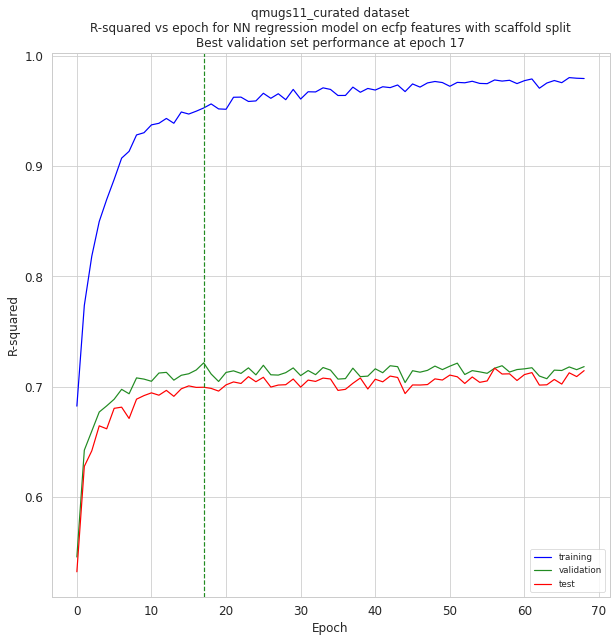

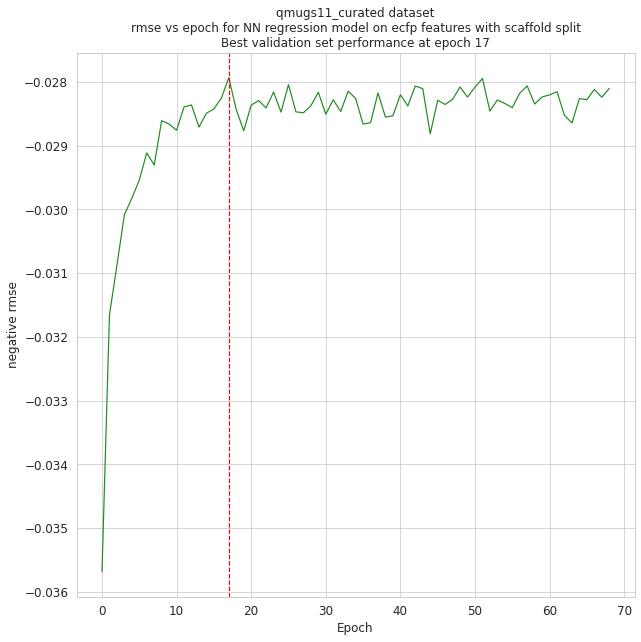

In [37]:
from atomsci.ddm.pipeline import perf_plots as pp
pp.plot_perf_vs_epoch(train_model)

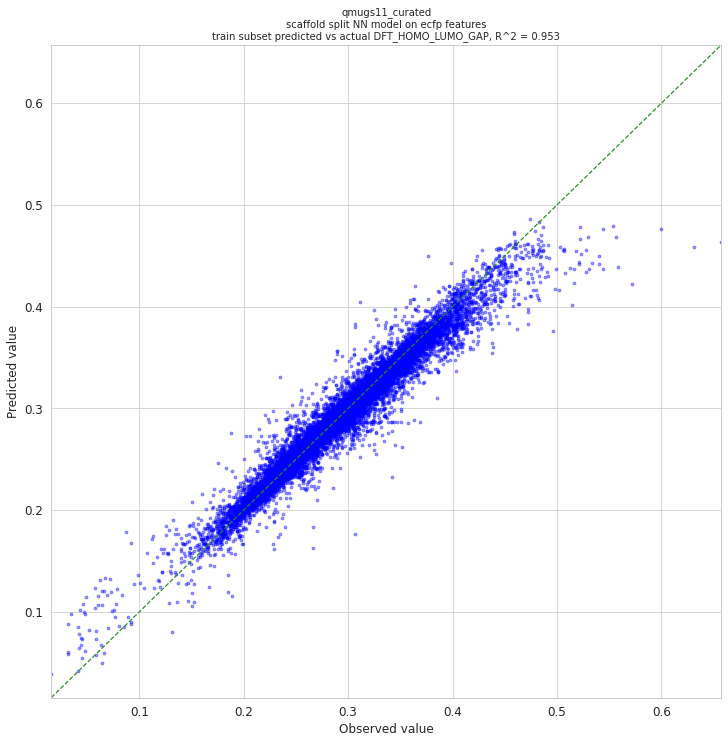

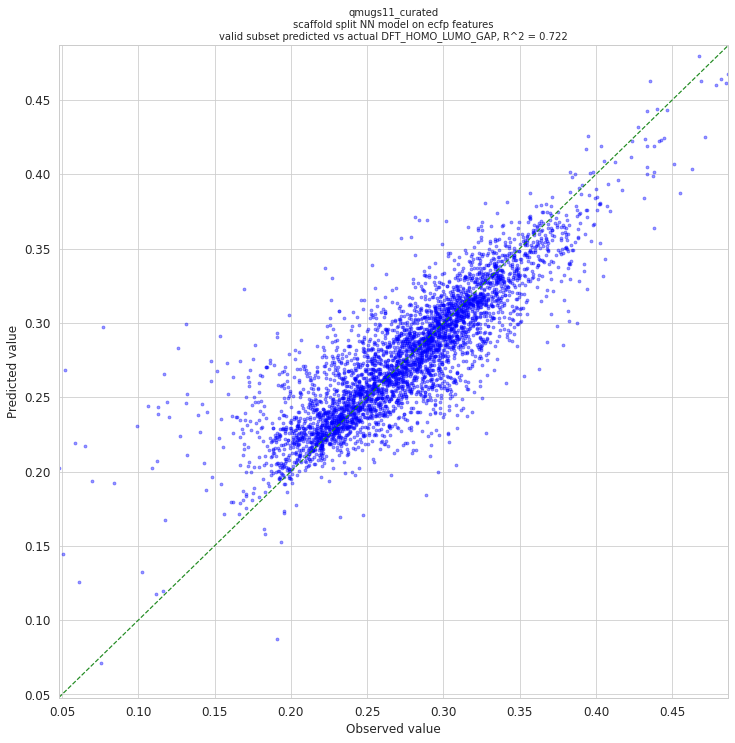

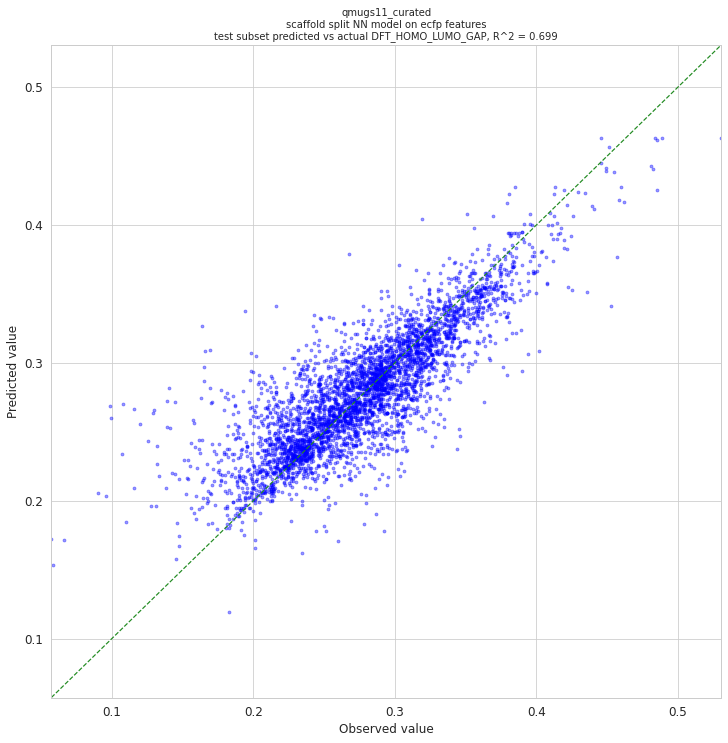

In [45]:
pp.plot_pred_vs_actual(train_model)